## Importing Required Packages

In [92]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.applications import VGG16 #VGG616 is our convolutional base trained on imagenet. You can also use Xception, Inception V3, ResNet50, etc.
from skimage.io import imread, imshow
from skimage import filters
from skimage.filters import prewitt_h,prewitt_v


## Setting up data extractor

In [7]:
def get_files(path):
    file_list = []
    for path, directories, files in os.walk(path):
        file_list = files
        return file_list

In [8]:
img_raw = cv2.imread(f'COVID19_Lung_CT/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png',0)
print(img_raw.shape)
a = np.array(img_raw).flatten()
print(a.shape)


(335, 580)
(194300,)


## Extracting COVID-19 data, normalizing & then adding to dataframe

In [76]:
c_path = "./COVID19_Lung_CT/CT_COVID"
c_files = get_files(c_path)
c_data = []


for img in c_files:
    img_raw = imread(f'{c_path}/{img}',as_gray=True)
    try:
        img_norm = cv2.resize(img_raw,(100,100)) # This needs to be improved with effective feature extraction
        img_flat = np.array(img_norm)
        c_data.append([img_flat,1]) # Assigning label 1 for COVID data
    except AssertionError: # Using try except clause makes sure we don't have any images which would not resize properly
        pass
        
print(len(c_data))

349


In [77]:
#pd.set_option("max_rows", None)
df = pd.DataFrame(c_data, columns = ['img_data', 'label'])
df['img_data'][0].shape

(100, 100)

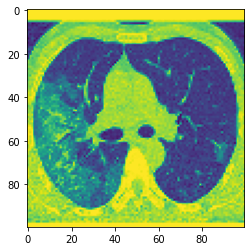

In [78]:
plt.imshow(df['img_data'][0])

In [12]:
df['img_data'][0].shape

(100, 100, 3)

In [13]:
a = df['img_data'][0].flatten()
a.shape

(30000,)

## Extracting Non COVID-19 data, normalizing & then adding to dataframe

In [81]:
nc_path = "./COVID19_Lung_CT/CT_NonCOVID"
nc_files = get_files(nc_path)
nc_data = []

for img in nc_files:
    img_raw = imread(f'{nc_path}/{img}', as_gray=True)
    try:
        img_norm = cv2.resize(img_raw,(100,100))
        img_flat = np.array(img_norm)
        nc_data.append([img_flat,0])
    except AssertionError:
        pass
    
print(len(nc_data))

397


In [82]:
df2 = pd.DataFrame(nc_data, columns = ['img_data', 'label'])
df2

,img_data,label
0,"[[0.2632633333333333, 0.2583370588235294, 0.27...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.07507049019607843, 0.07422735294117647, 0....",0
3,"[[0.00784313725490196, 0.00784313725490196, 0....",0
4,"[[253, 255, 255, 255, 255, 255, 255, 255, 255,...",0
...,...,...
392,"[[0.00392156862745098, 0.00392156862745098, 0....",0
393,"[[0.32794196078431376, 0.35105254901960786, 0....",0
394,"[[0.8358914705882353, 0.9086700980392157, 0.93...",0
395,"[[0.1607843137254902, 0.16405882352941176, 0.1...",0


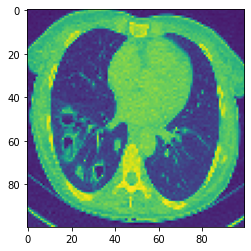

In [84]:
plt.imshow(df2['img_data'][0])

### Merging data frames

In [85]:
img_master = df.append(df2, ignore_index=True)
img_master

,img_data,label
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1
1,"[[0.16887098039215664, 0.16213725490196063, 0....",1
2,"[[0.008992941176470585, 0.021698823529411757, ...",1
3,"[[0.011470588235294118, 0.006078431372549021, ...",1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
...,...,...
741,"[[0.00392156862745098, 0.00392156862745098, 0....",0
742,"[[0.32794196078431376, 0.35105254901960786, 0....",0
743,"[[0.8358914705882353, 0.9086700980392157, 0.93...",0
744,"[[0.1607843137254902, 0.16405882352941176, 0.1...",0


In [86]:
img_final = img_master.sample(frac=1).reset_index(drop=True) #Shuffling dataframe and resetting index values
img_final

,img_data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00076862745098039...",1
1,"[[0.00784313725490196, 0.00784313725490196, 0....",0
2,"[[0.3100571568627451, 0.30980392156862746, 0.3...",0
3,"[[0.15321568627450985, 0.1568627450980392, 0.1...",0
4,"[[0.1811372549019608, 0.1818823529411765, 0.18...",0
...,...,...
741,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
742,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1
743,"[[0.17412254901960783, 0.17227990196078433, 0....",0
744,"[[0.11675333333333333, 0.08327882352941177, 0....",1


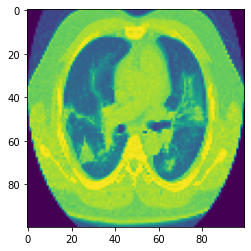

In [87]:
plt.imshow(img_final['img_data'][0])

In [88]:
len(img_final)

746

### Applying feature extraction layer

In [104]:
img_final['img_data'] = img_final['img_data'].apply(lambda x: filters.sobel(x))


In [113]:
img_final

,img_data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.002175392773225305, 0....",1
1,"[[0.0011888709239921205, 0.003805246131449978,...",0
2,"[[0.0005765464573423615, 0.0001368422653260878...",0
3,"[[0.0025788600255038504, 0.0025788600255038504...",0
4,"[[0.0026888479247151945, 0.0023898474568420243...",0
...,...,...
741,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
742,"[[0.18749999999999997, 0.47598581911649424, 0....",1
743,"[[0.007745399361421052, 0.004328822335534231, ...",0
744,"[[0.02029252563235518, 0.009684066907279574, 0...",1


(100, 100)

### Training & Testing Split

In [140]:
y_df = img_final[['label']]
X_df = img_final[['img_data']]


In [124]:
X = np.asarray(X_df)
y = np.asarray(y_df)
y = y.flatten()

In [125]:
X_final = []
for i in X: # Just use reshape here instead
    for g in i:
        X_final.append(g)
    

In [126]:
X_f = np.array(X_final)

In [130]:
X_f.shape
XX = np.reshape(X_f, (746,100*100))
XX.shape

(746, 10000)

In [131]:
y.shape

(746,)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
     XX, y, random_state=600)

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (559, 10000)
X_test.shape  = (187, 10000)
y_train.shape = (559,)
y_test.shape  = (187,)


### Implementing SVM Model

In [133]:
sv = SVC(C=1,kernel='poly',gamma = 'auto')

In [134]:
sv.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='poly')

In [135]:
predict = sv.predict(X_test)

In [136]:
print(f'Model accuracy is {accuracy_score(y_test, predict)*100:.2f}%')

Model accuracy is 51.87%


In [138]:
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
y_test

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])